In [71]:
# Objective: find minimum and maximum "reasonable values" for the frequency contribution values

%matplotlib notebook 
import matplotlib
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize as imresize
import numpy as np
import scipy
import glob

In [3]:
# implement 2D DCT
def dct2(img):
    from scipy.fftpack import dct
    return dct(dct(img.T, norm='ortho').T, norm='ortho')

# implement 2D IDCT
def idct2(img):
    from scipy.fftpack import idct
    return idct(idct(img.T, norm='ortho').T, norm='ortho')

In [79]:
def run_experiment(src, plot=True, detail=16):
    img_full = rgb2gray(imread(src))
    img_base = imresize(img_full, (64,64))
    img_base -= 0.5
    img_freq1 = dct2(img_base)
    img_freq2 = np.zeros(img_freq1.shape)
    
    img_freq2[0:detail,0:detail] = img_freq1[0:detail,0:detail]
    img_remade = idct2(img_freq2)
    
    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9,3))
        ax1.set_title('Original')
        ax1.imshow(img_base, cmap='gist_gray')
        ax2.set_title('Frequency Space [0:{}]'.format(detail))
        ax2.imshow(img_freq2[0:detail,0:detail])
        ax3.set_title('Reconstructed')
        ax3.imshow(img_remade, cmap='gist_gray')
    
    return img_freq2[0:detail,0:detail]

In [85]:
imgs = glob.glob('../test-media/imgs/*/*')
num_img = len(imgs)
limits = np.zeros((num_img,2))
avg_freq_frame = np.zeros((16,16))
min_freq_frame = np.zeros((16,16))
max_freq_frame = np.zeros((16,16))
first = True
for i in range(num_img):
    freq_frame = run_experiment(imgs[i], plot=False)
    limits[i] = [freq_frame.min(), freq_frame.max()]
    print(imgs[i], limits[i,0], limits[i,1])
    avg_freq_frame += freq_frame
    if first:
        first = False
        min_freq_frame = freq_frame.copy()
        max_freq_frame = freq_frame.copy()
    else:
        min_freq_frame = np.minimum(min_freq_frame, freq_frame)
        max_freq_frame = np.maximum(max_freq_frame, freq_frame)
        
avg_freq_frame /= num_img
print(limits.min(), limits.max())

../test-media/imgs/aerials/2.1.01.tiff -4.039164279526936 2.592906354398396
../test-media/imgs/aerials/2.1.02.tiff -1.6471817007754705 5.035607666129497
../test-media/imgs/aerials/2.1.03.tiff -1.750409731965542 0.6724393721539247
../test-media/imgs/aerials/2.1.04.tiff -0.6484275981913181 3.566724424087278
../test-media/imgs/aerials/2.1.05.tiff -2.7281466638762075 2.117066253204578
../test-media/imgs/aerials/2.1.06.tiff -2.6738396633449177 5.856741332968196
../test-media/imgs/aerials/2.1.07.tiff -0.705362178950102 10.269570379028469
../test-media/imgs/aerials/2.1.08.tiff -0.523723405233305 14.743723439170449
../test-media/imgs/aerials/2.1.09.tiff -2.289438235045125 9.478370124774118
../test-media/imgs/aerials/2.1.10.tiff -0.8982104653877363 10.505260045658824
../test-media/imgs/aerials/2.1.11.tiff -5.016612644427128 1.7434327584732507
../test-media/imgs/aerials/2.1.12.tiff -1.3320200336682364 13.807404727636296
../test-media/imgs/aerials/2.2.01.tiff -9.053386333955626 2.0470907966616125

../test-media/imgs/textures/1.3.07.tiff -0.2790586182335452 15.756020220588233
../test-media/imgs/textures/1.3.08.tiff -0.15082971697654865 13.437101715686273
../test-media/imgs/textures/1.3.09.tiff -0.4227154859886979 23.84937193627451
../test-media/imgs/textures/1.3.10.tiff -0.25683084480558405 18.87026654411764
../test-media/imgs/textures/1.3.11.tiff -0.2368556141387621 14.06187193627451
../test-media/imgs/textures/1.3.12.tiff -1.325825640999565 18.505284926470587
../test-media/imgs/textures/1.3.13.tiff -0.63282298678071 7.56484375
../test-media/imgs/textures/1.4.01.tiff -6.287362132352948 1.6332762469870727
../test-media/imgs/textures/1.4.02.tiff -2.356647500479473 1.7018389195730539
../test-media/imgs/textures/1.4.03.tiff -2.8344480919337958 2.5776287645259366
../test-media/imgs/textures/1.4.04.tiff -9.65255821078432 3.265145989684754
../test-media/imgs/textures/1.4.05.tiff -5.331936875569113 10.624476334306927
../test-media/imgs/textures/1.4.06.tiff -6.818382352941178 1.619112491

<IPython.core.display.Javascript object>


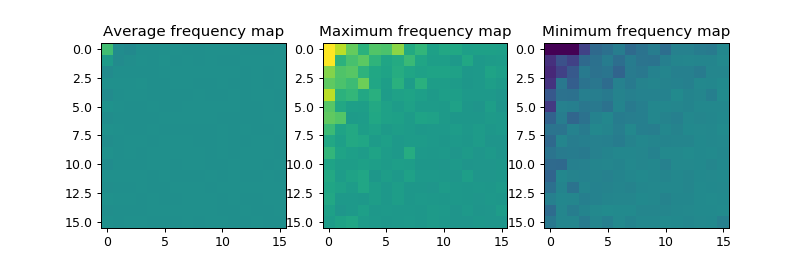

In [104]:
avg_freq_frame

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9,3))
# The -8 and +8 were determined "experimentally" (but they are half of the side length)
ax1.set_title('Average frequency map')
ax1.imshow(avg_freq_frame, vmin=-8, vmax=8)
ax2.set_title('Maximum frequency map')
ax2.imshow(max_freq_frame, vmin=-8, vmax=8)
ax3.set_title('Minimum frequency map')
ax3.imshow(min_freq_frame, vmin=-8, vmax=8)

Restrciting the frequency contribution values to -8 to +8 seems adequate as very few times the actual value is outside this range.

### Applying square roots

For each pixel we apply:
$x' = \operatorname{sign}(x)\cdot\sqrt{|x|}$ Where $x$ is the old value and $x'$ is the new value.

<IPython.core.display.Javascript object>


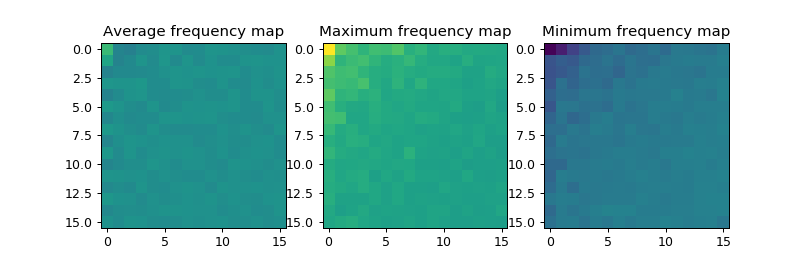

In [106]:
def transf_sqrt_one(a):
    return np.sign(a) * np.sqrt(abs(a))

avg_freq_frame_sqrt = transf_sqrt(avg_freq_frame)
min_freq_frame_sqrt = transf_sqrt(min_freq_frame)
max_freq_frame_sqrt = transf_sqrt(max_freq_frame)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9,3))
# The -5 and +5 were determined "experimentally"
ax1.set_title('Average frequency map')
ax1.imshow(avg_freq_frame_sqrt, vmin=-5, vmax=5)
ax2.set_title('Maximum frequency map')
ax2.imshow(max_freq_frame_sqrt, vmin=-5, vmax=5)
ax3.set_title('Minimum frequency map')
ax3.imshow(min_freq_frame_sqrt, vmin=-5, vmax=5)

### Applying logarithms

For each pixel we apply:
$x' = \operatorname{sign}(x)\cdot\log(|x|+1)$ Where $x$ is the old value and $x'$ is the new value.

<IPython.core.display.Javascript object>


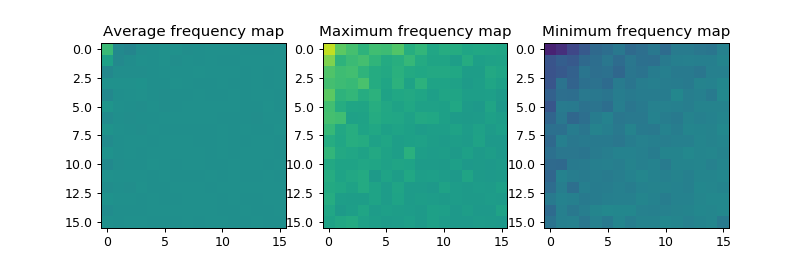

In [99]:
def transf_log_one(a):
    return np.sign(a) * np.log(abs(a)+1)
transf_log = np.vectorize(transf_log_one)
\operatorname{sign}(x)\cdot
avg_freq_frame_log = transf_log(avg_freq_frame)
min_freq_frame_log = transf_log(min_freq_frame)
max_freq_frame_log = transf_log(max_freq_frame)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9,3))
# The -4 and +4transf_sqrt were determined "experimentally"
ax1.set_title('Average frequency map')
ax1.imshow(avg_freq_frame_log, vmin=-4, vmax=4)
ax2.set_title('Maximum frequency map')
ax2.imshow(max_freq_frame_log, vmin=-4, vmax=4)
ax3.set_title('Minimum frequency map')
ax3.imshow(min_freq_frame_log, vmin=-4, vmax=4)